In [2]:
import requests
import zipfile
import io
import yaml
import pandas as pd
import numpy as np

def generate_data(yamlFile):
    '''
    generate data and return csv names
    '''
    
    url = "http://oasis.caiso.com/oasisapi/SingleZip"
    extract_directory = ""
    params = {
        "resultformat": "6",
        "queryname": yamlFile["forecast_type"],
        "market_run_id": yamlFile["market_run_id"],
        "execution_type": yamlFile["execution_type"],
        "version": "1",
        "startdatetime": "20240101T08:00-0000",
        "enddatetime": "20240130T08:00-0000"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.content

        zip_data = io.BytesIO(data)
        csv = None
        with zipfile.ZipFile(zip_data, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            print(file_list)
            for file_name in file_list:
                csv = file_name[:-25]+".csv"
                file_data = zip_ref.read(file_name)
                with open(file_name[:-25]+".csv", 'wb') as file:
                    file.write(file_data)
        return csv
    else:
        print("Request failed with status code:", response.status_code)
        return None

In [3]:
def split_data(csv, yamlFile):
  '''
  split data from one csv to specific dataset
  '''
  
  data = pd.read_csv(csv)

  # print(data.shape)

  zone_id = yamlFile["zone_id"]
  training_set_start = yamlFile["training_set_start"]
  training_set_end = yamlFile["training_set_end"]
  validation_set_start = yamlFile["validation_set_start"]
  validation_set_end = yamlFile["validation_set_end"]

  training_set = data.query(f'OPR_DT <= "{training_set_end}" and OPR_DT >= "{training_set_start}"')
  validation_set = data.query(f'OPR_DT <= "{validation_set_end}" and OPR_DT >= "{validation_set_start}"')

  # print(validation_set.shape)
  return training_set, validation_set

In [14]:
import matplotlib.pyplot as plt

def visualization(id_list, yamlFile):
  ''' 
  visualize for four types within a graph
  '''
  
  def subrun(run_id, exec_type, yamlFile):
    yamlFile['market_run_id'] = run_id
    yamlFile['execution_type'] = exec_type
    with open('config.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set = split_data(csv, yamlFile)
    time_series = pd.concat([training_set['INTERVALSTARTTIME_GMT'], validation_set['INTERVALSTARTTIME_GMT']])
    MW = pd.concat([training_set['MW'], validation_set['MW']])
    time_series, MW = np.array(time_series), np.array(MW)
    index = np.argsort(time_series)
    return time_series[index], MW[index]
    
  plt.figure()
  for run_id in id_list:
    if run_id=='RTM':
      for exec_type in ['RTD', 'RTPD']:
        time_series, MW = subrun(run_id, exec_type, yamlFile)
        plt.scatter(time_series, MW, s=0.5, label=f"{run_id} with {exec_type}")
    else:
      exec_type = None
      time_series, MW = subrun(run_id, exec_type, yamlFile)
      print(time_series)
      plt.scatter(time_series, MW, s=0.5, label=f"{run_id}")
  plt.legend()
  plt.show()

['20240101_20240130_SLD_FCST_ACTUAL_20240309_13_50_48_v1.csv']
['2024-01-01T08:00:00-00:00' '2024-01-01T08:00:00-00:00'
 '2024-01-01T08:00:00-00:00' ... '2024-01-30T07:00:00-00:00'
 '2024-01-30T07:00:00-00:00' '2024-01-30T07:00:00-00:00']


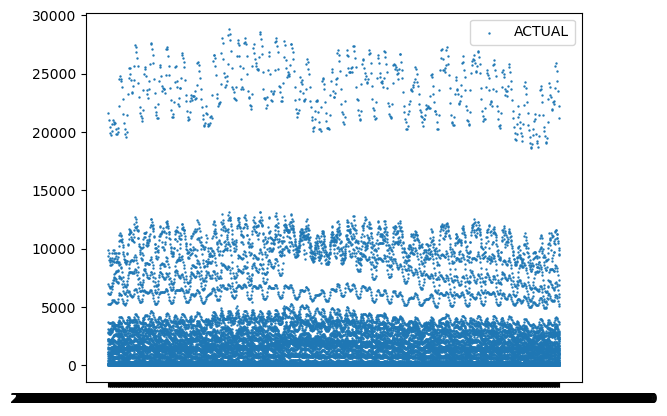

In [15]:
with open("config.yaml") as file:
  yamlFile = yaml.safe_load(file)
# csv = generate_data(yamlFile)
# split_data(csv, yamlFile)
# visualization(['ACTUAL', 'DAM', 'RTM'], yamlFile)
visualization(['ACTUAL'], yamlFile)
# visualization(['RTM'], yamlFile)
# visualization(['DAM'], yamlFile)
